In [5]:
import numpy as np
import qutip as qt
from matplotlib import pyplot as plt
from scipy.special import hermite

In [6]:
# ### Define system parameters

N = 100  # Size of the Hilbert space
omega = 1.0  # Oscillator frequency
m = 1.0  # Mass of the particle
hbar = 1.0  # Planck's constant in natural units

# Position and momentum scaling factors
x_0 = 1 / np.sqrt(2 * m * omega)  # x_0: characteristic length scale
p_0 = np.sqrt(m * omega / 2)  # p_0: characteristic momentum scale

# ### Define operators for the quantum harmonic oscillator

a = qt.destroy(N)  # Annihilation operator
id_op = qt.identity(N)  # Identity operator
n_op = a.dag() * a  # Number operator

x_op = (a + a.dag()) * x_0  # Position operator
p_op = -1j * (a - a.dag()) * p_0  # Momentum operator

# Hamiltonian of the harmonic oscillator
H0 = omega * (a.dag() * a + 0.5 * id_op)

# Alternatively: 
# H0 = p ** 2 / (2 * m) + m * (omega * x) ** 2 / 2


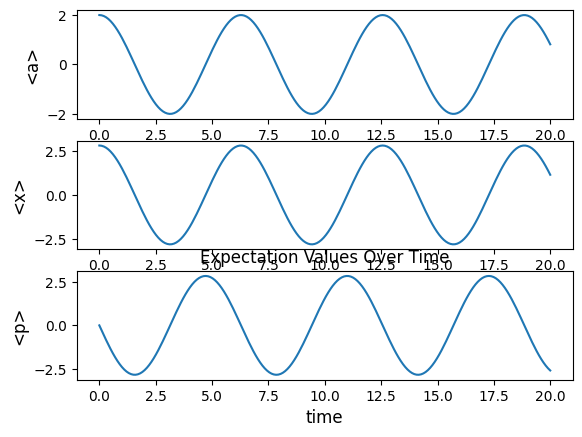

<Figure size 800x400 with 0 Axes>

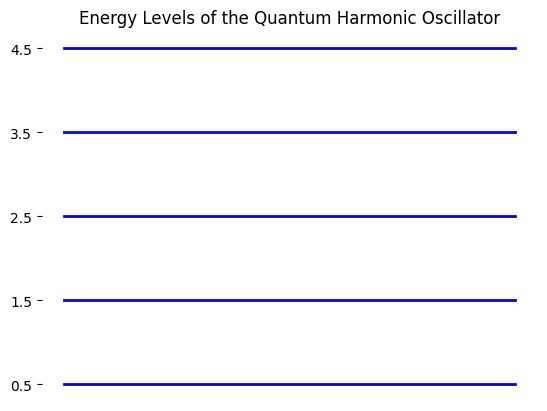

In [12]:
# ### Set up the initial state of the system

# Define a coherent state as the initial state
alpha = 2.0
psi0 = qt.coherent(N, alpha)

# ### Define observables for tracking

e_ops = [a, x_op, p_op]  # Operators to track expectation values of

# ### Time evolution parameters

times = np.linspace(0, 20, 200)  # Time array

# ### Time evolution of the system

# Using mesolve to simulate time evolution
result = qt.mesolve(H0, psi0, times, [], e_ops)

# ### Plot expectation values of observables over time

qt.plot_expectation_values(result, ylabels=['<a>', '<x>', '<p>'])
plt.title("Expectation Values Over Time")
plt.show()

# ### Energy levels of the Hamiltonian

fig = plt.figure(figsize=(8, 4))
qt.plot_energy_levels([H0/omega], N=5)
plt.title("Energy Levels of the Quantum Harmonic Oscillator")
plt.show()


The Ehrenfest Theorem provides a bridge between quantum mechanics and classical mechanics by describing the time evolution of expectation values. Specifically, it states that for position `x` and momentum `p`, the time evolution of their quantum expectation values follows the classical equations of motion.

The theorem for a particle in a potential `V(x)` is given by:
$$
\frac{d}{dt} \langle x \rangle = \frac{\langle p \rangle}{m}, \quad \frac{d}{dt} \langle p \rangle = - \left\langle \frac{dV}{dx} \right\rangle =  - m \omega^2 \left\langle x \right\rangle
$$

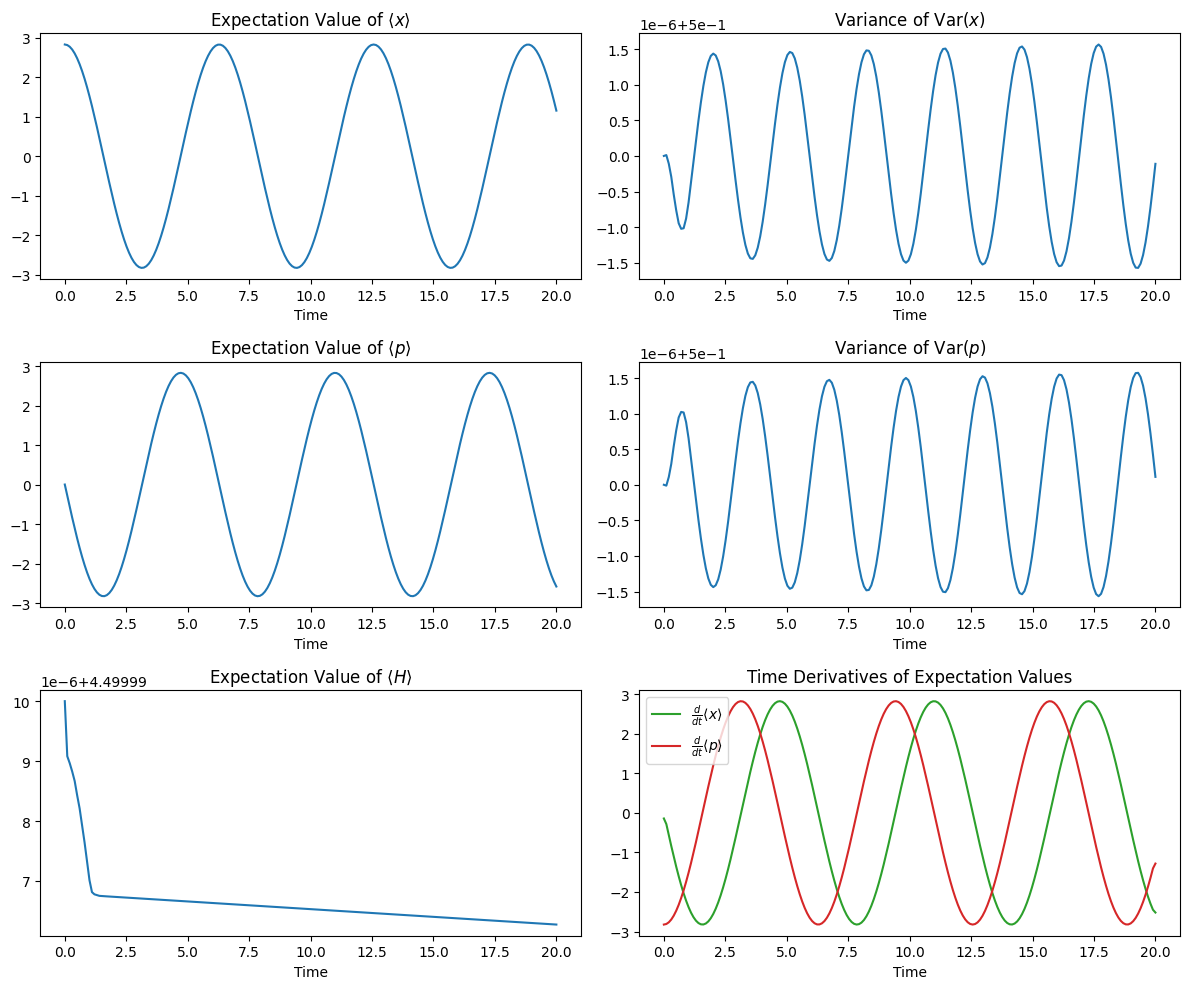

In [13]:
# ### Calculate expectation values, variances, and derivatives
# Using mesolve to simulate time evolution
result = qt.mesolve(H0, psi0, times, [])

expect_vals = [np.real([qt.expect(op, state) for state in result.states]) for op in [x_op, p_op, H0]]
variances = [np.real([qt.variance(op, state) for state in result.states]) for op in [x_op, p_op]]
x_dot, p_dot = [np.gradient(vals, times[1] - times[0]) for vals in expect_vals[:2]]

# ### Plotting results for expectation values, variances, and derivatives

fig, axs = plt.subplots(3, 2, figsize=(12, 10))
labels = [r"$\langle x \rangle$", r"$\langle p \rangle$", r"$\langle H \rangle$"]

# Expectation values
for i, vals in enumerate(expect_vals):
    axs[i, 0].plot(times, vals, label=labels[i])
    axs[i, 0].set_title(f"Expectation Value of {labels[i]}")
    axs[i, 0].set_xlabel("Time")

# Variances
var_labels = [r"$\text{Var}(x)$", r"$\text{Var}(p)$"]
for i, var in enumerate(variances):
    axs[i, 1].plot(times, var, label=var_labels[i])
    axs[i, 1].set_title(f"Variance of {var_labels[i]}")
    axs[i, 1].set_xlabel("Time")

# Time derivatives of expectation values
axs[2, 1].plot(times, x_dot, label=r"$\frac{d}{dt}\langle x \rangle$", color="tab:green")
axs[2, 1].plot(times, p_dot, label=r"$\frac{d}{dt}\langle p \rangle$", color="tab:red")
axs[2, 1].set_title("Time Derivatives of Expectation Values")
axs[2, 1].set_xlabel("Time")
axs[2, 1].legend()

plt.tight_layout()
plt.show()

In [16]:
def osc_wf(x_zpf,n,x):
    """
    Calculate the wavefunction in the position representation from the analytical solution.
    
    Parameters:
    - x_zpf: float, position zero point fluctuation
    - n: int, fock state number
    - x: array, position grid points
    
    Returns:
    - psi_x: array, the wavefunction in position representation 
    """
    H = hermite(n) # Hermite polynomial of degree n

    # Helper function to ensure convergence of factorial for high number state
    def one_over_sqrt_factorial(lvl):
        if lvl <= 170:
            return np.math.factorial(lvl)**-.5
        else:
            return (np.math.factorial(170)**-.5 * (np.math.factorial(lvl)/ np.math.factorial(170))**-.5)
 
    return (np.sqrt(2*np.pi*x_zpf)* (2**n) )**-.5 * H(x/(x_zpf*np.sqrt(2)))* one_over_sqrt_factorial(n) * np.exp(-x**2/(4*x_zpf**2))

def eigen_wf(x_zpf, x, state_vector):
    """
    Calculate the wavefunction in the position representation from the analytical solution.
    
    Parameters:
    - x_zpf: float, position zero point fluctuation
    - state_vector: Qobj, quantum state in the Fock basis
    - x: array, position grid points
    
    Returns:
    - psi_x: array, the wavefunction in position representation 
    """
    # Initialize the wavefunction to 0
    wf = np.zeros_like(x, dtype=complex)
    
    for n, coeff in enumerate(state_vector):
        wf += coeff[0] * osc_wf(x_zpf,n,x) # add the n fock state component to the total wavefunction
    return wf

def eigen_wf_p_representation(psi_x, x_values, hbar=1.0):
    """
    Calculate the wavefunction in the momentum representation from the position representation.
    
    Parameters:
    - psi_x: array, the wavefunction in position representation 
    - x_values: array, the x grid points where psi_x is defined
    - hbar: float, reduced Planck's constant (default is 1 for convenience)
    
    Returns:
    - p_values: array, the momentum grid points
    - psi_p: array, the wavefunction in momentum representation 
    """
    # Calculate spacing in x space
    dx = x_values[1] - x_values[0]
    N = len(x_values)
    
    # Calculate the momentum grid values
    p_values = np.fft.fftfreq(N, d=dx) * 2 * np.pi * hbar

    # Fourier transform and scaling factor
    psi_p = np.fft.fft(psi_x) * dx / np.sqrt(2 * np.pi * hbar)
    
    # Re-order the FFT output and corresponding p values to match increasing p order
    p_values = np.fft.fftshift(p_values)
    psi_p = np.fft.fftshift(psi_p)

    return p_values, psi_p

def classical_tp_abs(omega,m,n,hbar):
    """
    Calculate the classical turning point.
    """
    return np.sqrt(2*hbar/ (omega*m) * (n + .5))


/tmp/ipykernel_16987/2634687051.py:18: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.math.factorial(lvl)**-.5


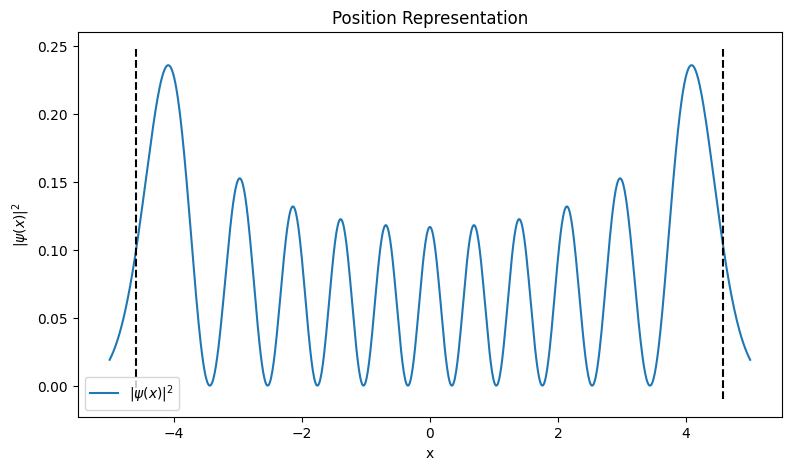

In [28]:
# ### Define position and calculate wavefunctions

x_values = np.linspace(-5, 5, 1001)
n_fock = 10
psi_x = eigen_wf(x_0, x_values, qt.basis(N, n_fock))
prob_x = np.abs(psi_x)**2

p_values, psi_p = eigen_wf_p_representation(psi_x, x_values)
prob_p = np.abs(psi_p)**2

# ### Plot probability densities in position and momentum spaces

plt.figure(figsize=(20, 5))

# Position representation
plt.subplot(1, 2, 1)
plt.plot(x_values, prob_x, label=r"$|\psi(x)|^2$")
plt.vlines([classical_tp_abs(omega,m,n_fock,1),-classical_tp_abs(omega,m,n_fock,1)],ymin=-0.01,ymax=1.05*max(prob_x),linestyles='dashed',colors='black')
plt.xlabel("x")
plt.ylabel(r"$|\psi(x)|^2$")
plt.title("Position Representation")
plt.legend()

# plt.tight_layout()
plt.show()


In [19]:
# # Set up figure for the animation of probability density
# fig, ax = plt.subplots(figsize=(10, 6))
# line, = ax.plot(x_values, np.abs(eigen_wf(x_0, x_values, result.states[0]))**2, lw=2)
# ax.set_ylim(0, 0.5)
# ax.set_xlabel("x")
# ax.set_ylabel(r"$|\psi(x, t)|^2$")
# ax.set_title("Probability Density $|\psi(x, t)|^2$ of Quantum Harmonic Oscillator")

# # Animation function to update the probability density
# def animate(i):
#     psi_t = result.states[i]  # Get state at time step i
#     line.set_ydata(np.abs(eigen_wf(x_0, x_values, psi_t))**2)
#     return line,

# from IPython.display import HTML
# from matplotlib.animation import FuncAnimation, PillowWriter

# # Run and display the animation in the notebook
# ani = FuncAnimation(fig, animate, frames=len(times), interval=100, blit=True)
# # ani.save("quantum_oscillator.mp4", writer="ffmpeg")
# HTML(ani.to_jshtml())

/tmp/ipykernel_16987/2634687051.py:18: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.math.factorial(lvl)**-.5


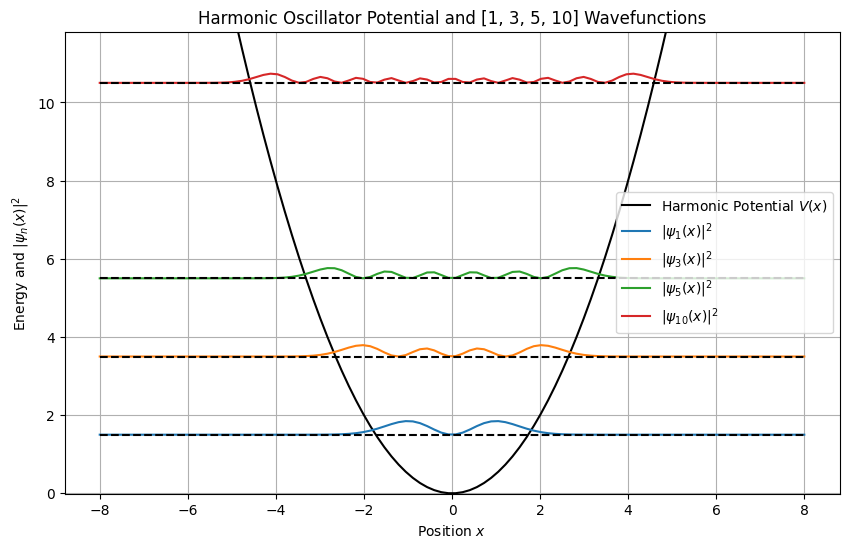

In [20]:
def harmonic_potential(x, omega, m=1):
    """
    Harmonic oscillator potential function.
    V(x) = 0.5 * m * omega^2 * x^2
    """
    return 0.5 * m * omega**2 * x**2

def plot_harmonic_oscillator_wavefunctions(x_0=np.sqrt(2)**-1, n_states=[5], omega=1.0, x_values=np.linspace(-8,8,100)):
    """
    Plots the harmonic oscillator potential and the first n_states wavefunctions.
    
    Parameters:
    - n_states: int, number of wavefunctions to plot
    - omega: float, oscillator frequency
    - x_min, x_max: float, range for x values in the plot
    - num_points: int, number of points to calculate for x
    """
    # Calculate the potential
    potential = harmonic_potential(x_values, omega)
    
    # Initialize the plot
    plt.figure(figsize=(10, 6))
    
    # Plot the potential
    plt.plot(x_values, potential, label="Harmonic Potential $V(x)$", color='black', linestyle="-")
    
    # Plot each wavefunction, scaling it to fit with the potential for visibility
    for n in n_states:
        psi_n = osc_wf(x_0,n,x_values)
        
        # Scale and shift wavefunction plot for better visibility
        plt.plot(x_values, psi_n**2 + (n+.5) * omega, label="$|\psi_{%i}(x)|^2$"%(n))

        plt.hlines((n+.5) * omega, xmin=min(x_values), xmax=max(x_values), linestyles='dashed', colors='black')
    
    # Customize plot
    plt.xlabel("Position $x$")
    plt.ylabel("Energy and $|\psi_n(x)|^2$")
    plt.title(f"Harmonic Oscillator Potential and {n_states} Wavefunctions")
    plt.ylim([-.01,1.1*max(psi_n**2+ (n+.5) * omega)])
    plt.legend()
    plt.grid()
    plt.show()


# Example: Plot the first 5 wavefunctions of the harmonic oscillator with ω = 1.0
plot_harmonic_oscillator_wavefunctions(n_states=[1,3,5,10], omega=1.0)

In [32]:

def find_extrema_distances_array(f_values, x_values, num_extrema=10, tolerance=None):
    """
    Find the positions of the extrema and distances between consecutive extrema.
    
    Parameters:
    - f_values: array-like, values of the function at points x_values
    - x_values: array-like, the x-values at which f_values are given
    - num_extrema: int, the maximum number of extrema to consider
    - tolerance: float, the minimum separation between extrema (in x units).
                 If None, defaults to 1.5 times the x spacing.
    
    Returns:
    - extrema_positions: list, x-positions of the extrema
    - extrema_distances: list, distances between consecutive extrema
    """
    # Set default tolerance based on x_values step size if not provided
    if tolerance is None:
        tolerance = 1.5 * (x_values[1] - x_values[0])

    # Find where the derivative changes sign to locate extrema
    derivative = np.diff(f_values)
    sign_changes = np.where(np.diff(np.sign(derivative)))[0] + 1  # +1 for alignment with x_values indexing

    # Initialize lists to store extrema positions and filter duplicates
    extrema_positions = []
    last_extremum = None

    for idx in sign_changes:
        x_extremum = x_values[idx]
        
        # Filter based on tolerance to avoid close duplicate extrema
        if last_extremum is None or abs(x_extremum - last_extremum) > tolerance:
            extrema_positions.append(x_extremum)
            last_extremum = x_extremum
        
        # Stop if we've collected the desired number of extrema
        if len(extrema_positions) >= num_extrema:
            break

    # Calculate distances between consecutive extrema
    extrema_distances = np.diff(extrema_positions)

    return extrema_positions, extrema_distances

def find_wavelength(list):
    """
    Find the distance between extrema i and extrema i+2 around x=0
    
    Parameters:
    - list: list, distances between consecutive extrema
    Returns:
    - wavelength: float, wavefunction de Broglie wavelength

    """
    length = len(list)  

    first_middle_index = length // 2 
    second_middle_index = length // 2 - 1 

    wavelength = list[first_middle_index] + list[second_middle_index]

    return wavelength

from scipy.signal import find_peaks


def DeBroglie_wavelength(n_array, x_0, x_values):
    DeBroglie_wavelength_vs_n = []
    for n in n_array:
        psi_n = osc_wf(x_0, n ,x_values)
        peaks, _ = find_peaks(psi_10_squared, distance=20)  # Adjust `distance` to avoid detecting minor peaks

        _ , extrema_distances = find_extrema_distances_array(psi_n, x_values, num_extrema = n)
        print(extrema_distances)
        DeBroglie_wavelength_vs_n.append(find_wavelength(extrema_distances))

    return DeBroglie_wavelength_vs_n

In [33]:
# Find the extrema of the amplitude and distances between them
psi_n = osc_wf(x_0, 2, x_values)
extrema_positions, extrema_distances = find_extrema_distances_array(psi_n, x_values, num_extrema=10)

/tmp/ipykernel_16987/2634687051.py:18: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.math.factorial(lvl)**-.5


In [34]:
n_values = [10]
DeBroglie_wavelength(n_values, x_0, x_values)

[0.13792812 0.14130427 0.14473553 ... 0.14473553 0.14130427 0.13792812]
[1.12 0.83 0.75 0.7  0.69 0.69 0.7  0.75 0.83]


/tmp/ipykernel_16987/2634687051.py:18: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.math.factorial(lvl)**-.5


[1.3900000000000001]

/tmp/ipykernel_16987/2634687051.py:18: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.math.factorial(lvl)**-.5
/tmp/ipykernel_16987/2885107664.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


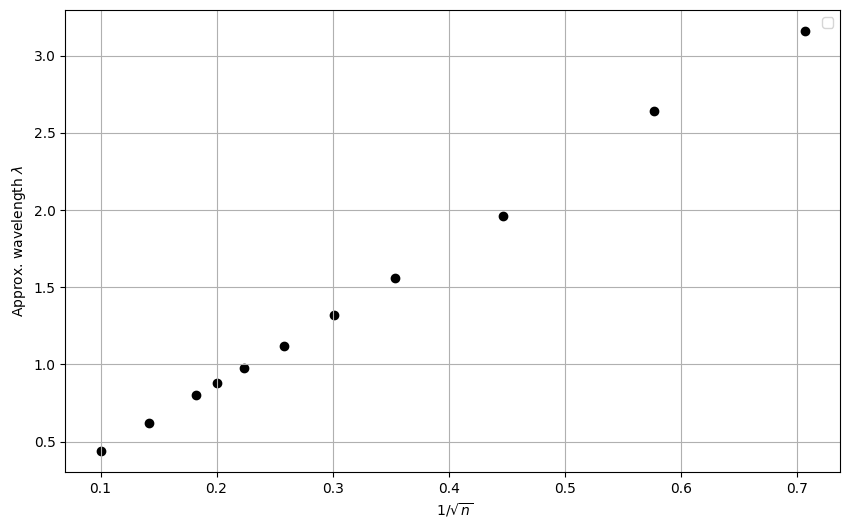

In [23]:
n_values = [2, 3, 5, 8, 11, 15, 20, 25, 30, 50, 100]

l_approx = DeBroglie_wavelength(n_values, x_0, x_values)

plt.figure(figsize=(10, 6))
plt.scatter(np.asarray(n_values)**-.5, l_approx, color='black', linestyle="-")

# Customize plot
plt.xlabel(" $1 / \sqrt{n}$")
plt.ylabel("Approx. wavelength $\lambda$")
# plt.title(f"Harmonic Oscillator Potential and {n_states} Wavefunctions")
plt.legend()
plt.grid()
plt.show()
